# Original text

## Problem-3: Solving 0–1 Knapsack Problem Using Bees Algorithm (BA)  
Overview
Use the Bees Algorithm (BA) to solve 0–1 Knapsack problem— pick the best items under a
weight limit. Here, the aim is to select a subset of items with maximum total value without
exceeding a weight capacity.


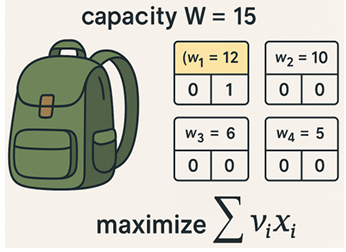




Problem Description
You are given n items. Each item i has value 𝑣> 0	and weight 𝑤> 0. Choose a subset to
maximize total value while keeping total weight ≤ 𝑊.
Decision: 𝑥 ∈ {0,1}	(1 = take item 𝑖, 0 = skip).
Objective (maximize):

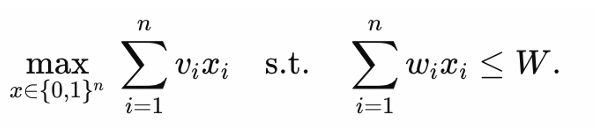

maximize:    sum(v_i * x_i) for i = 1..n \
subject to:  sum(w_i * x_i) <= W \
x_i ∈ {0, 1}

(If your code minimizes, use fitness = -sum(v_i * x_i) with a feasibility repair or penalty.)



Data Requirements (explicit, public)
Use OR-Library 0/1 knapsack instances.
* OR-Library – Multidimensional Knapsack (MKP) info & downloads (incl. classic
literature sets):  
https://people.brunel.ac.uk/~mastjjb/jeb/orlib/mknapinfo.html
* Pisinger’s “hard” 0/1 knapsack instances (knapPI_… series) + generators + solutions:
https://hjemmesider.diku.dk/~pisinger/codes.html
* Optional extra) Small 0/1 knapsack datasets for teaching (Burkardt collection):
https://people.sc.fsu.edu/~jburkardt/datasets/knapsack_01/knapsack_01.html
In your report, name the exact instance IDs you solved (e.g., weing1, weing2, or
knapPI_1_50_100).

Evaluation Protocol
* Instances: solve at least 6 (six) named OR-Library instances (small, medium, large).
* Metrics:
  * Primary: best value 𝑉(𝑥) (feasible).
  * Secondary: runtime; iterations to best; average fitness of population.

Plots/Tables
* Convergence: iteration versus best value.
* Statistics of final best values over 10 runs (using different random seeds).
* Table: instance, n, W, best value, weight used, baseline value, improvement %.
Deliverables
* Code: BA knapsack solver (with repair) + baselines; a README (how to run on each
instance).
* Report:  
  * Instances used.
  * Implementation details, including every step and component of BA, so that the implementation can be reproduced.  
  * BA settings,  
  * Neighbourhood choices,  
  * Convergence plot,  
  * Brief discussion of sensitivity (effect of nre, nrb and ngh).
  * Plots/Tables mentioned above.

Grading / Success Criteria
* Correctness: final solution feasible (𝑊(𝑥) ≤ 𝑊); repair implemented correctly.
* Effectiveness.
* Clarity & Reproducibility: clean code, fixed seed option, labeled figures, README.

-------------------------------------------------------
-------------------------------------------------------

# 0–1 Knapsack with the Bees Algorithm (BA)

In [1]:
from pathlib import Path
import numpy as np

data_path = Path("./data/Knapsack/mknapcb6.txt")

with open(data_path, "r") as f:
    raw = f.read().split()

print(f"Total number of entries in the file: {len(raw)}")
print("First 50 numbers in the dataset:")
print(raw[:50])


Total number of entries in the file: 165391
First 50 numbers in the dataset:
['30', '500', '10', '0', '653', '854', '738', '768', '812', '375', '452', '600', '790', '848', '1074', '748', '815', '556', '718', '821', '899', '545', '456', '833', '623', '910', '864', '421', '805', '780', '713', '453', '632', '790', '626', '895', '539', '668', '853', '800', '710', '772', '968', '409', '503', '687', '618', '486', '981', '664']


In [2]:

data = list(map(float, raw))

# The first few numbers might describe metadata (e.g., number of items or constraints)
print("First 10 values:", data[:10])

# Let's try to see if the first value could be a count (integer-like?)
print("First value (maybe number of instances?):", data[0])
print("Next few values (possibly structure info?):", data[1:4])


First 10 values: [30.0, 500.0, 10.0, 0.0, 653.0, 854.0, 738.0, 768.0, 812.0, 375.0]
First value (maybe number of instances?): 30.0
Next few values (possibly structure info?): [500.0, 10.0, 0.0]


Instances = 30.0 \
structure = 500.0, 10.0, 0.0

In [3]:

ptr = 0
num_instances = int(data[ptr]); ptr += 1

# Maybe these represent (n, m, instance_id)?
n = int(data[ptr]); ptr += 1
m = int(data[ptr]); ptr += 1
ptr += 1  # An extra 0
print(f"\nPossible structure: n={n}, m={m}")


Possible structure: n=500, m=10



The next 500 values seem like a list of positive numbers (likely 'profits' or 'values').\
First 10 profit-like values: [653. 854. 738. 768. 812. 375. 452. 600. 790. 848.]

The dataset seems to describe:
- 500 items
- 10 constraints
- A 10×500 matrix of coefficients
- And a vector of 10 capacity limits

In [4]:
# Let's see what the next n numbers look like — maybe profits or weights?
profits = np.array(data[ptr:ptr+n]); ptr += n
print(f"\nThe next {n} values seem like a list of positive numbers (likely 'profits' or 'values').")
print("First 10 profit-like values:", profits[:10])

# Then we appear to have several rows of coefficients — maybe resource constraints
rows = []
for _ in range(m):
    row = np.array(data[ptr:ptr+n])
    rows.append(row)
    ptr += n
constraints = np.vstack(rows)

# Finally, there are probably m capacity values
capacities = np.array(data[ptr:ptr+m]); ptr += m

print("Shapes and a quick sample:")
print("profits shape:", profits.shape)
print("constraints shape:", constraints.shape)
print("capacities shape:", capacities.shape)
print("First few capacities:", capacities)


The next 500 values seem like a list of positive numbers (likely 'profits' or 'values').
First 10 profit-like values: [653. 854. 738. 768. 812. 375. 452. 600. 790. 848.]
Shapes and a quick sample:
profits shape: (500,)
constraints shape: (10, 500)
capacities shape: (10,)
First few capacities: [60589. 62150. 59432. 61740. 62977. 61186. 60721. 60640. 65126. 57802.]


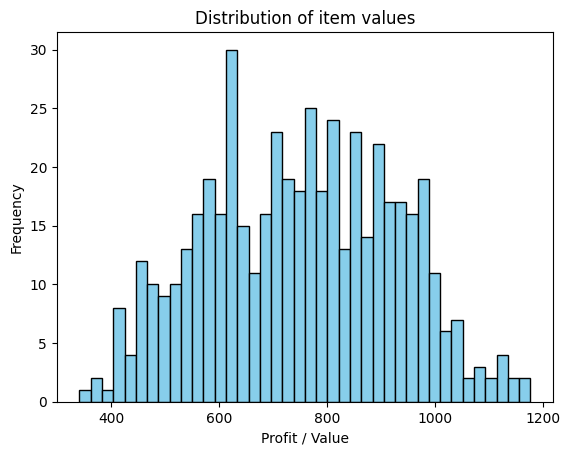

In [5]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(profits, bins=40, color="skyblue", edgecolor="black")
plt.title("Distribution of item values")
plt.xlabel("Profit / Value")
plt.ylabel("Frequency")
plt.show()

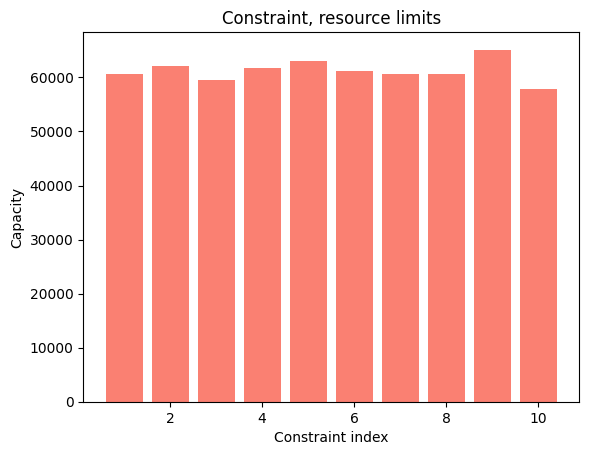

In [6]:
plt.figure()
plt.bar(np.arange(len(capacities))+1, capacities, color="salmon")
plt.title("Constraint, resource limits")
plt.xlabel("Constraint index")
plt.ylabel("Capacity")
plt.show()
